Implementation of http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=mnist

In [218]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tnrange
import scipy.ndimage
import cv2
import os
import csv
import pandas as pd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


RESIZE = 128
BATCH_SIZE = 256

#### Pokemon Dataloader

In [219]:
pokelist = os.listdir("./Pokemon/")
with open("./PokeList", 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(pokelist)

In [220]:
# Dataloader class that works with VCTK datasets. Init require the path to a folder where voice_data are stored.
class PokeSet(Utils.Dataset): # Main dataset class for dataloader
    def __init__(self, path): # takes two input, the input and output Tensors
        self.path = path
        self.pokelist = pd.read_csv("PokeList",header=None)

    
    def __len__(self): # must be written for dataset module
        return len(os.listdir(self.path))
    
    def __getitem__(self,index): # must be written for dataset module
        pokemon = mpimg.imread(self.path + self.pokelist[index][0])
        pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
        pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
        return pokemon
    
pokeSet = PokeSet("./Pokemon/")
pokeLoader = Utils.DataLoader(dataset = pokeSet, shuffle = True, batch_size = BATCH_SIZE)

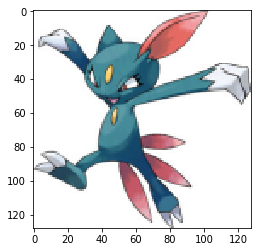

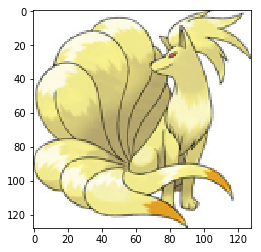

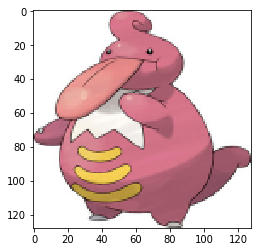

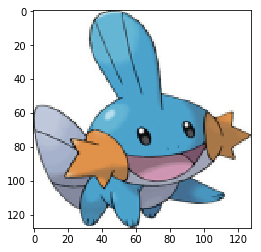

In [221]:
for i, data in enumerate(pokeLoader):
    if i in range(10):
#         print(data[0,:,:,:].size())
        plt.imshow(data[0,:,:,:].squeeze().numpy())
        plt.show()

#### Define Network

In [222]:
class Net(nn.Module):
    def __init__(self, latent_dim=256):
        super(Net, self).__init__()
        
        #encoder
        self.conv_e1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bn_e1 = nn.BatchNorm2d(32)
        self.conv_e2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn_e2 = nn.BatchNorm2d(64)
        self.conv_e3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn_e3 = nn.BatchNorm2d(128)
        self.conv_e4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn_e4 = nn.BatchNorm2d(256)
        
        self.fc_mean = nn.Linear(256*RESIZE//16*RESIZE//16, latent_dim)
        self.fc_logvar = nn.Linear(256*RESIZE//16*RESIZE//16, latent_dim)
        
        #decoder
        self.fc_d = nn.Linear(latent_dim, 256*RESIZE//16*RESIZE//16)
        
        self.up = nn.Upsample(scale_factor=2)
        
        self.conv_d1 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn_d1 = nn.BatchNorm2d(128)
        self.conv_d2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn_d2 = nn.BatchNorm2d(64)
        self.conv_d3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn_d3 = nn.BatchNorm2d(32)
        self.conv_d4 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        
    def encoder(self, x):
        ''' encoder: q(z|x)
            input: x, output: mean, logvar
        '''
#         print("0 = ", x.shape)
        x = F.leaky_relu(self.bn_e1(self.conv_e1(x)))
#         print("1 = ", x.shape)
        x = F.leaky_relu(self.bn_e2(self.conv_e2(x)))
#         print("2 = ", x.shape)
        x = F.leaky_relu(self.bn_e3(self.conv_e3(x)))
#         print("3 = ", x.shape)
        x = F.leaky_relu(self.bn_e4(self.conv_e4(x)))
#         print("4 = ", x.shape)
#         print("--------")
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        return z_mean, z_logvar
    
    def latent(self, z_mu, z_logvar):
        ''' 
            encoder: z = mu + sd * e
            input: mean, logvar. output: z
        '''
        sd = torch.exp(z_logvar * 0.5)
        e = Variable(torch.randn(sd.size()))
        z = e.mul(sd).add_(z_mu)
        return z 
    
    def decoder(self, z):
        '''
            decoder: p(x|z)
            input: z. output: x
        '''
        x = self.fc_d(z)
        x = x.view(-1, 256, RESIZE//16, RESIZE//16)
        x = F.leaky_relu(self.bn_d1(self.conv_d1(self.up(x))))
        x = F.leaky_relu(self.bn_d2(self.conv_d2(self.up(x))))
        x = F.leaky_relu(self.bn_d3(self.conv_d3(self.up(x))))
        x = F.sigmoid(self.conv_d4(self.up(x)))
        return x.view(-1,3,RESIZE,RESIZE)

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.latent(z_mean, z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar


net = Net()

#### Define Loss Function

Loss Function

$$ 2+2 = 4 - 1 = 3 , Quikmafz$$

## $$l_i(\theta, \phi) = E_{z\sim q_\theta(z\vert x_i)}[\log p_\phi(x_i\vert z)] - KL(q_\theta(z\vert x_i) \vert\vert p(z))$$

In [223]:
import torch.optim as optim
#Define Criterion

def criterion(x_out, target, z_mean, z_logvar, alpha = 1, beta = 0.5):
    bce = F.mse_loss(x_out, target, size_average=False) #Use MSE loss for images
    kl = -0.5 * torch.sum(1 + z_logvar - (z_mean**2) - torch.exp(z_logvar)) #Analytical KL Divergence - Assumes p(z) is Gausian Distribution
    loss = ((alpha * bce) + (beta * kl)) / x_out.size(0)    
    return loss, bce, kl

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

#### Train Network

In [ ]:
# Training
def train(model,optimizer,dataloader,epochs=50):
    losses = []
    bces = []
    kls = []
    for epoch in range(epochs):
        for images in dataloader:
            images = images.permute(0,3,1,2)
            x_in = Variable(images.float())
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss, bce, kl = criterion(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
            bces.append(bce.data[0])
            kls.append(kl.data[0])
        print(epoch, 'Loss: {:3f}'.format(loss.data[0]))
    return losses, bces, kls

train_losses, bces, kls = train(net,optimizer,pokeLoader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(bces)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(kls)
plt.show()

0 Loss: 6455.091797
1 Loss: 4965.525391
2 Loss: 3834.835449
3 Loss: 3233.260254
4 Loss: 2831.669434
5 Loss: 2593.713867
6 Loss: 2333.244629
7 Loss: 2250.677979
8 Loss: 2109.300537
9 Loss: 1993.949707
10 Loss: 1939.911133
11 Loss: 2018.612427
12 Loss: 2006.488159
13 Loss: 1854.777466
14 Loss: 1850.175415
15 Loss: 1829.109985
16 Loss: 1743.528564
17 Loss: 1721.257202
18 Loss: 1642.602173
19 Loss: 1671.445435
20 Loss: 1761.036865


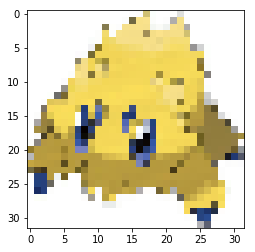

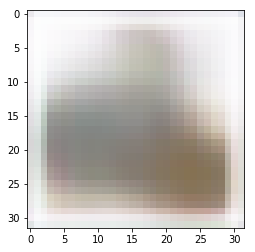

In [217]:
dataiter = iter(pokeLoader)

image = dataiter.next()
image = image[0,:,:,:].unsqueeze(0)
plt.imshow((image.squeeze().numpy()))
plt.show()
image = image.permute(0,3,1,2)
x_out, z_mean, z_logvar = net(Variable(image.float()))
x_out = x_out.permute(0,2,3,1)
plt.imshow(x_out.data.squeeze().numpy())
plt.show()
z = net.latent(z_mean, z_logvar)

In [ ]:
plt.imshow(x_out.data, cmap='gray')

z = net.latent(z_mean, z_logvar)
print(z)

In [ ]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(net,testloader)

In [ ]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid'):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, _ = data

        # wrap them in Variable
        inputs = Variable(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_out, z_mean, z_logvar = net(inputs)
        loss = criterion(x_out, inputs, z_mean, z_logvar)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

#### Testing Network

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

#Predict with network
outputs, _, _ = net(Variable(images))

# _, predicted = torch.max(outputs.data, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))


imshow(torchvision.utils.make_grid(outputs.data))

In [ ]:
#Test network accuracy

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs, _, _ = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

#### RUN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

torch.manual_seed(2017) # reproducability
sns.set_style('dark')
%matplotlib inline

In [ ]:
# Model
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,784)
            
    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)
    
    def sample_normal(self,mean,logvar):
        # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
        # Instead we utilize the 'reparameterization trick'.
        # http://stats.stackexchange.com/a/205336
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size())) # Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

model = VAE()

In [ ]:
# Loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Data loaders
trainloader = DataLoader(
    MNIST(root='./MNIST',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./MNIST',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

In [ ]:
# Training
def train(model,optimizer,dataloader,epochs=15):
    losses = []
    for epoch in range(epochs):
        for images,_ in dataloader:
            x_in = Variable(images)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        print('Loss: {:4f}'.format(loss.data[0]))
    return losses

train_losses = train(model,optimizer,trainloader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()